<font color='blue'> 
    
## Комментарий ревьюера
<t>          
Привет! Меня зовут Аслан Шаков, и я буду проверять твой проект по анализу бизнес показателей. Предлагаю общаться на «ты».

У тебя получился отличный проект. Почти все основные этапы в работе выполнены, так что в целом задача выполнена. Есть ещё несколько моментов, которые требуют твоего внимания. Комментарии по ним помечены красным цветом. После их доработки проект будет принят. Осталось совсем немного, буду ждать твою работу на повторное ревью 🙂
Зелёным цветом отмечены удачные и красивые решения, на которые можно опираться в будущих проектах. Жёлтым цветом выделено то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас (однако это не обязательно). 

Давай работать над проектом в диалоге: если ты **что-то меняешь** в проекте по моим рекомендациям — **пиши об этом**. Выбери для своих комментариев какой-то заметный цвет, так мне будет легче отследить изменения. Пожалуйста, **не перемещай, не изменяй и не удаляй мои комментарии**. Всё это поможет выполнить повторную проверку твоего проекта оперативнее».

<font color='blue'> 
    
## Комментарий ревьюера (2)
<t>          
Спасибо за исправления. Мои комментарии будут ниже с отметой (2) и с каждой итерацией будет +1.

# Аналитика в Яндекс.Афише

## Описание проекта:

У вас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.

Нужно изучить:
* *как люди пользуются продуктом,*
* *когда они начинают покупать,*
* *сколько денег приносит каждый клиент*
* *когда клиент окупается.*

## Оглавление:

1. Шаг 1. Загрузка данных
2. Шаг 2. Отчёты и метрики
    * Продукт
    * Продажи
    * Маркетинг
3. Шаг 3. Вывод по маркетингу

## Описание данных

**Таблица `visits` (лог сервера с информацией о посещениях сайта):**
* Uid — уникальный идентификатор пользователя
* Device — категория устройства пользователя*
* Start Ts — дата и время начала сессии*
* End Ts — дата и время окончания сессии*
* Source Id — идентификатор рекламного источника, из которого пришел пользователь*

**Таблица `orders` (информация о заказах):**
* Uid — уникальный id пользователя, который сделал заказ*
* Buy Ts — дата и время заказа*
* Revenue — выручка Яндекс.Афиши с этого заказа*

**Таблица `costs` (информация о затратах на маркетинг):**
* source_id — идентификатор рекламного источника*
* dt — дата*
* costs — затраты на этот рекламный источник в этот день*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Шаг 1. Загрузка данных


In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
display(visits[:3])
display(orders[:3])
display(costs[:3])

Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527

Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844

source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53

Изменим названия признаков:

In [4]:
for df in [visits, orders, costs]:
    df.columns = map(str.lower, df.columns)
    df.columns = df.columns.str.replace(' ', '_')
    display(df[:3])
    display(df.shape)

device               end_ts  source_id             start_ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   

                    uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527

(359400, 5)

buy_ts  revenue                   uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844

(50415, 3)

source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53

(2542, 3)

In [5]:
visits['end_ts'] = visits['end_ts'].astype('datetime64')
visits['start_ts'] = visits['start_ts'].astype('datetime64')
orders['buy_ts'] = orders['buy_ts'].astype('datetime64')
costs['dt'] = costs['dt'].astype('datetime64[D]')

Добавим новые признаки, которые будем использовать при анализе данных:

In [6]:
# день посещения сайта 
visits['day'] = visits['start_ts'].astype('datetime64[D]')

In [7]:
# длительность сессии
visits['duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['duration_sec']

0         1080
1         1680
2            0
3         1440
4            0
          ... 
359395      19
359396      19
359397      19
359398      19
359399      19
Name: duration_sec, Length: 359400, dtype: int64

<div class="alert alert-warning">
<h2> Комментарий ревьюера</h2>

Все сделано правильно, но на этой стадии еще неплохо проверять данные на пропуски и дубликаты.
</div>

# Шаг 2. Отчёты и метрики

## Продукт

Узнаем количество уникальных пользователей в день, неделю, месяц

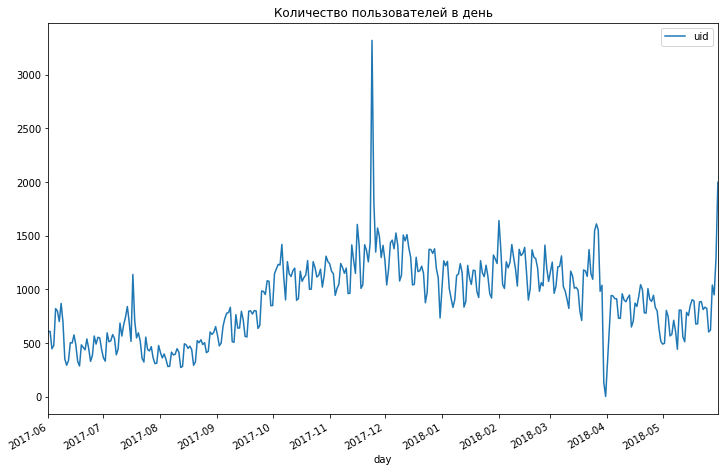

Среднее количество пользователей 
в день - 907,
в неделю - 5724,
в месяц 23228


In [8]:
visits.groupby('day').agg({'uid':'nunique'}).plot(figsize=(12,8))
plt.title('Количество пользователей в день')
plt.show()
in_day = visits.groupby('day').agg({'uid':'nunique'}).mean()
in_week = visits.groupby(visits['start_ts'].astype('datetime64[W]')).agg({'uid':'nunique'}).mean()
in_month = visits.groupby(visits['start_ts'].astype('datetime64[M]')).agg({'uid':'nunique'}).mean()
print(f"Среднее количество пользователей \nв день - {int(in_day)},\nв неделю - {int(in_week)},\nв месяц {int(in_month)}")


<div class="alert alert-success">
<h2> Комментарий ревьюера</h2>

Метрики dau, wau и mau рассчитаны правильно.
</div>

In [9]:
visits.groupby('day').agg({'uid':'nunique'}).sort_values(by='uid').tail(1)

uid
day             
2017-11-24  3319

In [10]:
visits[visits['start_ts'].astype('datetime64[D]') == "2017-11-24"].groupby('source_id').agg({'device':'count'})

device
source_id        
1             615
2             612
3             965
4             783
5             417
9             567
10             83

Видно, что в ноябре 2017 года был пик активности, но понять его причины не выйдет, так как нет расшифровки `source_id`

---

Рассчитаем среднее количество сессий в день

Среднее количество сессий в день - 987


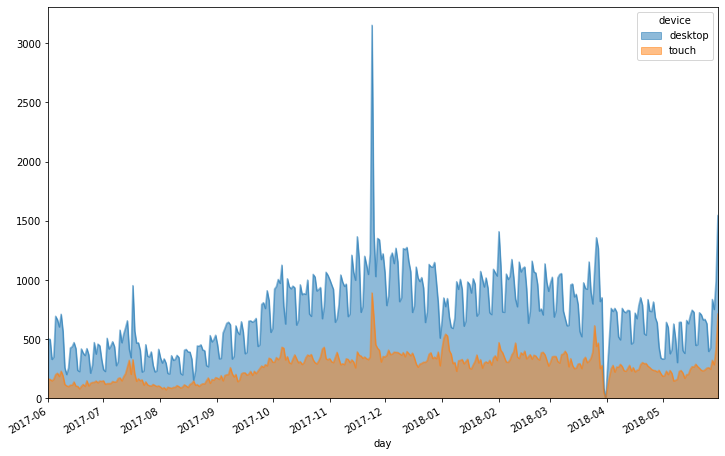

In [11]:
print(f"Среднее количество сессий в день - {int(visits.groupby('day').agg({'uid':'count'}).mean())}")
(
    visits
    .groupby(['device', 'day'])
    .agg({'uid':'count'})
    .reset_index()
    .pivot_table(values = 'uid', index = 'day', columns = 'device')
    .plot.area(figsize=(12,8), stacked=False)
)
plt.show()

<div class="alert alert-success">
<h2> Комментарий ревьюера</h2>

Тут тоже все верно, отличные графики.
</div>

Видно, что среднее количество сессий практически совпадает со средним количеством пользователей. Это значит, что на сайт редко заходят больше 1 раза в день.

Мобильный трафик более стабилен. В десктопном видна недельная цикличность.

---
Теперь выясним сколько длится сессия. В данных есть выбросы, поэтому для создания гистограммы ограничим значения продолжительности 2300 секунд (персентиль 0.95)

Чаще всего сессия длится 60 секунд


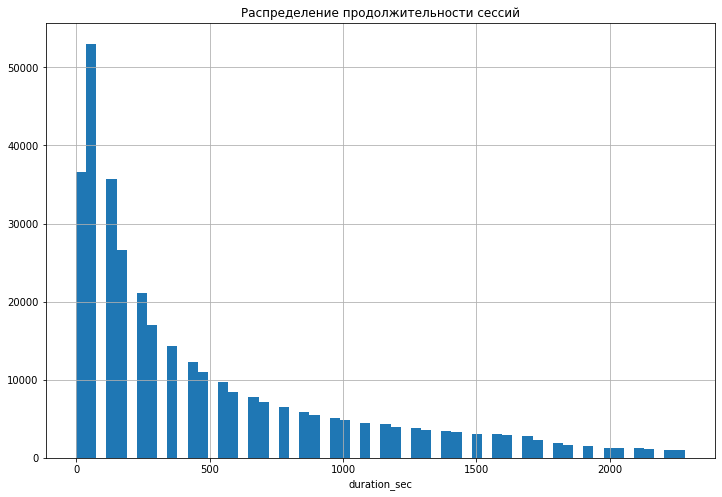

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
50%         300.000000
75%         840.000000
95%        2280.000000
99%        4500.000000
max       84480.000000
Name: duration_sec, dtype: float64

In [12]:
print(f"Чаще всего сессия длится {int(visits['duration_sec'].mode())} секунд")
visits.loc[visits['duration_sec'] < 2300, 'duration_sec'].hist(bins = 60, figsize=(12, 8))
plt.title('Распределение продолжительности сессий')
plt.xlabel('duration_sec')
plt.show()
display(visits.duration_sec.describe(percentiles=[0.75, 0.95, 0.99]))

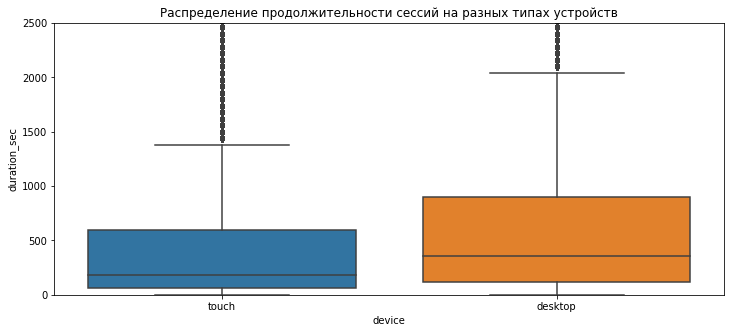

In [13]:
plt.figure(figsize=(12,5))
sns.boxplot(data = visits,
            x = 'device',
            y = 'duration_sec'
           )
plt.ylim(0,2500)
plt.title('Распределение продолжительности сессий на разных типах устройств')
plt.show()

По графику видно, что пользователи компьютера проводят на сайте больше времени, чем пользователи мобильных устройств, у половины пользователей продолжительность сессии меньше 5 минут

<div class="alert alert-success">
<h2> Комментарий ревьюера</h2>

Абсолютно верно. Молодец, что учитываешь какое распределние мы получили.
</div>

---

Узнаем как часто люди возвращаются

In [14]:
user_activity = visits[['uid', 'day']]
user_activity.columns = ['user_id', 'activity_date']
first_activity_date = user_activity.groupby(['user_id'])['activity_date'].min()
first_activity_date.name = 'first_activity_date'
user_activity = user_activity.join(first_activity_date,on='user_id') 
user_activity['activity_month'] = user_activity.activity_date.astype('datetime64[M]')
user_activity['first_activity_month'] = user_activity.first_activity_date.astype('datetime64[M]')
user_activity['cohort_lifetime'] = user_activity['activity_month'] - user_activity['first_activity_month']
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'] / np.timedelta64(1,'M')
user_activity['cohort_lifetime'] = user_activity['cohort_lifetime'].round().astype('int') 

cohorts = user_activity.groupby(['first_activity_month','cohort_lifetime']).agg({'user_id':'nunique'}).reset_index() 

initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','user_id']]

initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')


plt.figure(figsize=(12, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot[[i for i in range(1,12)]], annot=True, fmt='.1%', linewidths=1, linecolor='gray');

<div class="alert alert-warning">
<h2> Комментарий ревьюера</h2>

Здесь тоже все правильно, но нулевой месяц отрезать не нужно. Если сделал это, чтобы раскрасить тепловую карту, то это можно было сделать прописав параметр тепловой карты (в данном случае vmax=0.1), что ограничит верхний предел значений.
</div>

В таблице рассчитан процент людей, которые пользуются сервисом начиная со второго месяца. Видно, что сервисом продолжают пользоваться от 2 до 8 процентов пользователей

___

## Продажи

Узнаем сколько времени проходит между первым посещением сайта и первой покупкой

In [15]:
first_buy = (
    orders.groupby('uid')
    .agg(first_buy=('buy_ts', 'min'))
    .merge(visits.groupby('uid').agg(first_visit=('start_ts', 'min')).reset_index(), on='uid', how='left')
)
first_buy['delta_minute'] = (first_buy.first_buy - first_buy.first_visit).dt.seconds / 60
first_buy.head()

uid           first_buy         first_visit  delta_minute
0   313578113262317 2018-01-03 21:51:00 2017-09-18 22:49:00        1382.0
1  1575281904278712 2017-06-03 10:13:00 2017-06-03 10:13:00           0.0
2  2429014661409475 2017-10-11 18:33:00 2017-10-11 17:14:00          79.0
3  2464366381792757 2018-01-28 15:54:00 2018-01-27 20:10:00        1184.0
4  2551852515556206 2017-11-24 10:14:00 2017-11-24 10:14:00           0.0

In [16]:
display(first_buy.delta_minute.describe())
first_buy.delta_minute.hist(bins = 25, figsize=(12, 4))
plt.title('Распределение времени между посещением и покупкой')
plt.xlabel('delta_minute')
plt.show()

count    36523.000000
mean       249.164691
std        429.742785
min          0.000000
25%          4.000000
50%         16.000000
75%        252.000000
max       1439.000000
Name: delta_minute, dtype: float64

Половине  пользователей хватает 16 минут, чтобы совершить покупку

___

Узнаем сколько покупок совершается за неделю и за месяц и узнаем средний чек


количество покупок


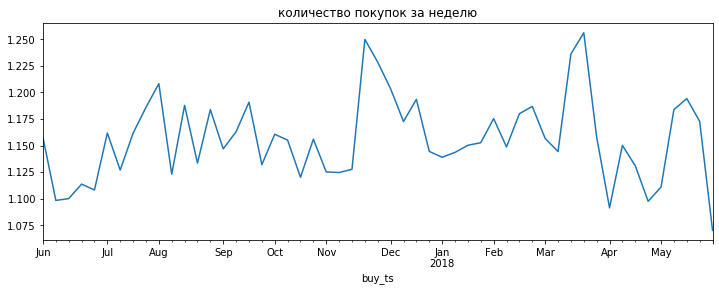

Mean количество покупок за неделю: 1.156124366245413
Mean количество покупок за месяц: 1.2058233446244648

средний чек


Mean средний чек за неделю: 5.77611793353189
Mean средний чек за месяц: 5.866513626792354


In [17]:
for metric, func in {'количество покупок' : ['uid', 'count'], 'средний чек' : ['revenue', 'sum']}.items():
    print()
    print(metric)
    buys_per_week = orders.groupby(orders.buy_ts.astype('datetime64[W]')).agg(buy_count=(func[0], func[1]), uniq_user=('uid', 'nunique'))
    buys_per_week['buys_per_user'] = buys_per_week.buy_count / buys_per_week.uniq_user
    buys_per_week.buys_per_user.plot(figsize=(12, 4))
    plt.title(metric + ' за неделю')
    plt.show()

    buys_per_month = orders.groupby(orders.buy_ts.astype('datetime64[M]')).agg(buy_count=(func[0], func[1]), uniq_user=('uid', 'nunique'))
    buys_per_month['buys_per_user'] = buys_per_month.buy_count / buys_per_month.uniq_user
    buys_per_month.buys_per_user.plot(figsize=(12, 4))
    plt.title(metric + ' за месяц')
    plt.show()
    print('Mean '+ metric + f' за неделю: {float(buys_per_week.buys_per_user.mean())}\nMean '+ metric + f' за месяц: {float(buys_per_month.buys_per_user.mean())}')

<div class="alert alert-danger">
<h2> Комментарий ревьюера</h2>

Здесь еще нужно посчитать сколько покупок приходится на одного покупателя. А средний чек считаем просто применением метода mean() к столбцу с выручкой в orders.
</div>

---
<font color=olive>
UPD

In [18]:
print()
print('Среднее число покупок в неделю на одного пользователя')
display(orders.groupby(['uid', orders.buy_ts.dt.week]).agg(order_sum = ('revenue', 'count')).mean())
orders.groupby(['uid', orders.buy_ts.dt.week]).agg(order_sum = ('revenue', 'count')).hist(bins=25)
plt.show()


Среднее число покупок в неделю на одного пользователя


order_sum    1.16448
dtype: float64


Среднее число покупок в месяц на одного пользователя


order_sum    1.229065
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4bd97f910>]],
      dtype=object)

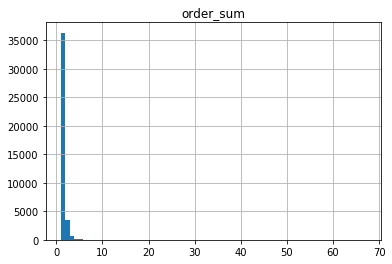

In [19]:
print()
print('Среднее число покупок в месяц на одного пользователя')
display(orders.groupby(['uid', orders.buy_ts.dt.month]).agg(order_sum = ('revenue', 'count')).mean())
orders.groupby(['uid', orders.buy_ts.dt.month]).agg(order_sum = ('revenue', 'count')).hist(bins=70)

Рассчитаем средний чек:

In [20]:
print(f'Средний чек равен {orders.revenue.mean():.2f}')

Средний чек равен 5.00


<font color = olive>
    
## Вывод
Обычно пользователи покупают не чаще одного раза в месяц
    
____

<div class="alert alert-success">
<h2> Комментарий ревьюера (2)</h2>

Правильно исправил.</div>

___

Узнаем LTV

In [21]:
orders['curr_month'] = orders['buy_ts'].astype('datetime64[M]')
orders = orders.merge(orders.groupby('uid').agg(first_month = ('buy_ts', 'min')), on = 'uid', how = 'left')
orders.first_month = orders.first_month.astype('datetime64[M]')
orders[:2]

buy_ts  revenue                   uid curr_month first_month
0 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01  2017-06-01
1 2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01  2017-06-01

In [22]:
cohort_size = orders.groupby('first_month').agg({'uid':'nunique'}).reset_index()
cohort_size[:2]

first_month   uid
0  2017-06-01  2023
1  2017-07-01  1923

In [23]:
cohorts = orders.groupby(['first_month', 'curr_month']).agg({'revenue': 'sum'}).reset_index()
cohorts[:2]

first_month curr_month  revenue
0  2017-06-01 2017-06-01  9557.49
1  2017-06-01 2017-07-01   981.82

In [24]:
report = pd.merge(cohort_size, cohorts, on='first_month')
report['age'] = (report['curr_month'] - report['first_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report.revenue / report.uid
report

first_month   uid curr_month   revenue  age       ltv
0   2017-06-01  2023 2017-06-01   9557.49    0  4.724414
1   2017-06-01  2023 2017-07-01    981.82    1  0.485329
2   2017-06-01  2023 2017-08-01    885.34    2  0.437637
3   2017-06-01  2023 2017-09-01   1931.30    3  0.954671
4   2017-06-01  2023 2017-10-01   2068.58    4  1.022531
..         ...   ...        ...       ...  ...       ...
74  2018-03-01  3533 2018-05-01   1114.87    2  0.315559
75  2018-04-01  2276 2018-04-01  10600.69    0  4.657597
76  2018-04-01  2276 2018-05-01   1209.92    1  0.531599
77  2018-05-01  2988 2018-05-01  13925.76    0  4.660562
78  2018-06-01     1 2018-06-01      3.42    0  3.420000

[79 rows x 6 columns]

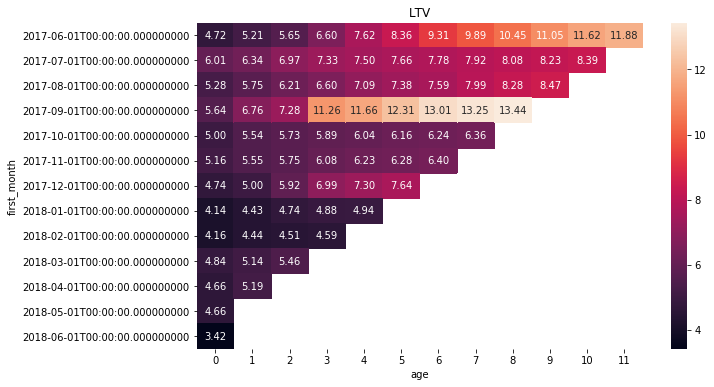

In [25]:
output = report.pivot_table(
        index='first_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(3)

plt.figure(figsize=(10, 6))
plt.title('LTV')
sns.heatmap(output.cumsum(axis=1), annot=True, fmt='.2f')
plt.show()

<div class="alert alert-success">
<h2> Комментарий ревьюера</h2>

Тут все отлично, так держать.
</div>

Рассмотрим, как будут меняться значения метрики в зависимости от девайса и рекламного источника

In [26]:
users = (
    visits[visits.uid.isin(orders.uid.unique())]
    .sort_values(by=['uid', 'start_ts'])
    .groupby('uid')
    .agg({'start_ts': 'first', 'source_id': 'first', 'device': 'first'})
    .reset_index()
              )
users.start_ts = users.start_ts.astype('datetime64[D]')
users[:3]

uid   start_ts  source_id   device
0   313578113262317 2017-09-18          2  desktop
1  1575281904278712 2017-06-03         10    touch
2  2429014661409475 2017-10-11          3  desktop

In [27]:
users = pd.merge(users, orders.groupby('uid').agg({'revenue':'sum'}), on='uid', how = 'left')

In [28]:
users[:4]

uid   start_ts  source_id   device  revenue
0   313578113262317 2017-09-18          2  desktop     0.55
1  1575281904278712 2017-06-03         10    touch     3.05
2  2429014661409475 2017-10-11          3  desktop    73.33
3  2464366381792757 2018-01-27          5  desktop     2.44

In [29]:
cohort_size_device_source = (
    pd.merge(users,
             orders,
             how = 'right',
             on = 'uid'
            )
    .groupby(['first_month', 'device', 'source_id'])
    .agg({'uid':'nunique'})
    .reset_index()
)

In [30]:
cohort_size_device_source[:20]

first_month   device  source_id  uid
0   2017-06-01  desktop          1  163
1   2017-06-01  desktop          2  191
2   2017-06-01  desktop          3  564
3   2017-06-01  desktop          4  339
4   2017-06-01  desktop          5  319
5   2017-06-01  desktop          9   60
6   2017-06-01  desktop         10   66
7   2017-06-01    touch          1   27
8   2017-06-01    touch          2   44
9   2017-06-01    touch          3   74
10  2017-06-01    touch          4   74
11  2017-06-01    touch          5   65
12  2017-06-01    touch          9    8
13  2017-06-01    touch         10   29
14  2017-07-01  desktop          1  138
15  2017-07-01  desktop          2  155
16  2017-07-01  desktop          3  430
17  2017-07-01  desktop          4  389
18  2017-07-01  desktop          5  333
19  2017-07-01  desktop          9   44

In [31]:
cohorts_device_source = (
    pd.merge(orders,
             users,
             how = 'left',
             on = 'uid',
             suffixes = ['_users', '_orders']
            )
    .groupby(['first_month', 'curr_month', 'device', 'source_id'])
    .agg({'revenue_users': 'sum'})
    .reset_index()
)
cohorts_device_source[:2]

first_month curr_month   device  source_id  revenue_users
0  2017-06-01 2017-06-01  desktop          1        1249.17
1  2017-06-01 2017-06-01  desktop          2         918.33

In [32]:
report_device = pd.merge(
    cohort_size_device_source.groupby(['first_month','device']).agg({'uid':'sum'}).reset_index(),
    cohorts_device_source.groupby(['first_month','curr_month','device']).agg({'revenue_users':'sum'}).reset_index(), 
    on=['first_month','device'])
report_device['age'] = (report_device['curr_month'] - report_device['first_month']) / np.timedelta64(1, 'M')
report_device['age'] = report_device['age'].round().astype('int')
report_device['ltv'] = report_device.revenue_users / report_device.uid
report_device#[:20].sort_values(by=['first_month', 'curr_month', 'device'])

first_month   device   uid curr_month  revenue_users  age       ltv
0    2017-06-01  desktop  1702 2017-06-01        8321.37    0  4.889172
1    2017-06-01  desktop  1702 2017-07-01         882.43    1  0.518467
2    2017-06-01  desktop  1702 2017-08-01         844.70    2  0.496298
3    2017-06-01  desktop  1702 2017-09-01        1905.09    3  1.119324
4    2017-06-01  desktop  1702 2017-10-01        1992.87    4  1.170899
..          ...      ...   ...        ...            ...  ...       ...
152  2018-04-01    touch   429 2018-04-01        1923.97    0  4.484779
153  2018-04-01    touch   429 2018-05-01          47.00    1  0.109557
154  2018-05-01  desktop  2349 2018-05-01       11425.64    0  4.864044
155  2018-05-01    touch   639 2018-05-01        2500.12    0  3.912551
156  2018-06-01  desktop     1 2018-06-01           3.42    0  3.420000

[157 rows x 7 columns]

In [33]:
report_source = pd.merge(
    cohort_size_device_source.groupby(['first_month','source_id']).agg({'uid':'sum'}).reset_index(),
    cohorts_device_source.groupby(['first_month','curr_month','source_id']).agg({'revenue_users':'sum'}).reset_index(), 
    on=['first_month','source_id'])
report_source['age'] = (report_source['curr_month'] - report_source['first_month']) / np.timedelta64(1, 'M')
report_source['age'] = report_source['age'].round().astype('int')
report_source['ltv'] = report_source.revenue_users / report_source.uid
report_source

first_month  source_id  uid curr_month  revenue_users  age       ltv
0    2017-06-01          1  190 2017-06-01        1378.70    0  7.256316
1    2017-06-01          1  190 2017-07-01         414.98    1  2.184105
2    2017-06-01          1  190 2017-08-01         419.43    2  2.207526
3    2017-06-01          1  190 2017-09-01         714.24    3  3.759158
4    2017-06-01          1  190 2017-10-01         811.20    4  4.269474
..          ...        ...  ...        ...            ...  ...       ...
511  2018-05-01          4  804 2018-05-01        3802.91    0  4.729988
512  2018-05-01          5  497 2018-05-01        2094.04    0  4.213360
513  2018-05-01          9   60 2018-05-01         223.05    0  3.717500
514  2018-05-01         10  130 2018-05-01         470.89    0  3.622231
515  2018-06-01          4    1 2018-06-01           3.42    0  3.420000

[516 rows x 7 columns]

In [34]:
df_device = pd.DataFrame()
for device in report_device.device.unique():
    output_device = report_device.query('device == @device').pivot_table(
        index='first_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(3)
    df_device[device] = output_device.sum(axis=1)
    



df_device.plot.bar(stacked=True, figsize=(12,8))
plt.title("Сравнение суммарного LTV разных когорт")
plt.xlabel("Когорта")


Text(0.5, 0, 'Когорта')

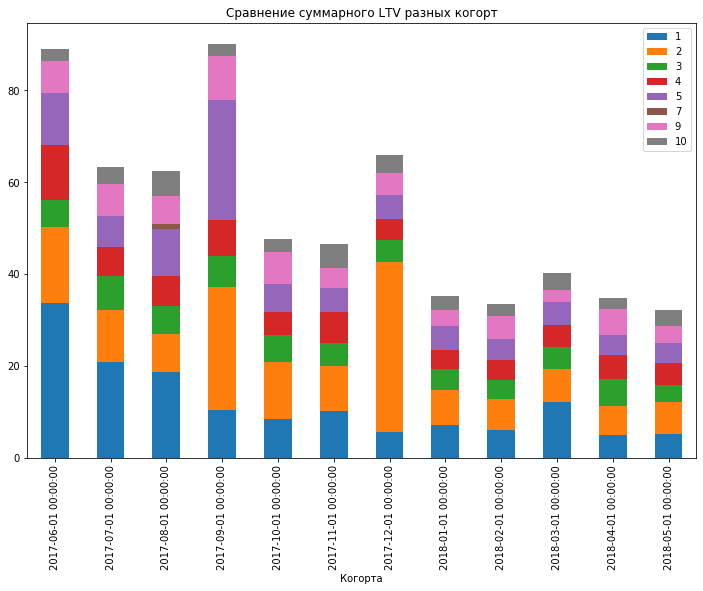

In [35]:
df_source = pd.DataFrame()
for source in sorted(report_source.source_id.unique()):
    output_source = report_source.query('source_id == @source').pivot_table(
        index='first_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(3)
    df_source[source] = output_source.sum(axis=1)
    
    
df_source.plot.bar(stacked=True, figsize=(12,8))
plt.title("Сравнение суммарного LTV разных когорт")
plt.xlabel("Когорта")
plt.show()


<div class="alert alert-danger">
<h2> Комментарий ревьюера</h2>

На последних двух графика в разрезах устройств и источников нет накопления по месяцам, хотя на тепловой карте оно есть, как и положено для LTV)
</div>


По полученным графикам можно сказать, что LTV выше у десктопа и рекламных источников "1", "2". В данных заметны трехмесячные циклы. LTV выше у когорт 06-2017, 09-2017, 12-2017, 03-2018 

<font color=olive>
UPD

Построим тепловую карту для всех девайсов

desktop


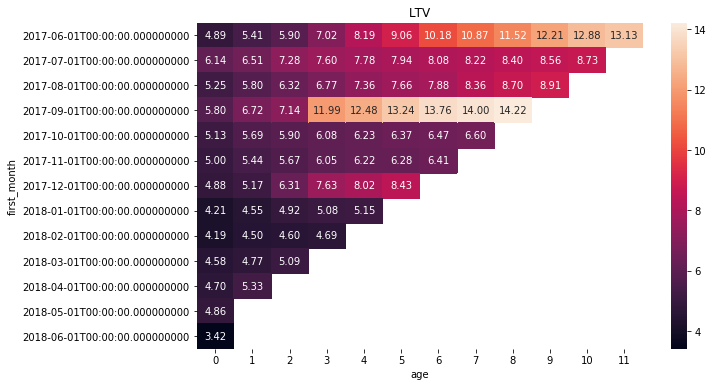

touch


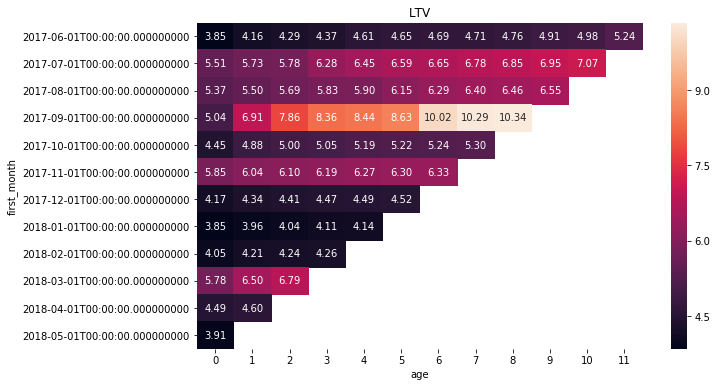

In [36]:
for dev in report_device.device.unique():
    
    output_device = report_device.query('device == @dev').pivot_table(
            index='first_month', 
            columns='age', 
            values='ltv', 
            aggfunc='mean').round(3)
    
    print(dev)
    plt.figure(figsize=(10, 6))
    plt.title('LTV')
    sns.heatmap(output_device.cumsum(axis=1), annot=True, fmt='.2f')
    plt.show()

1


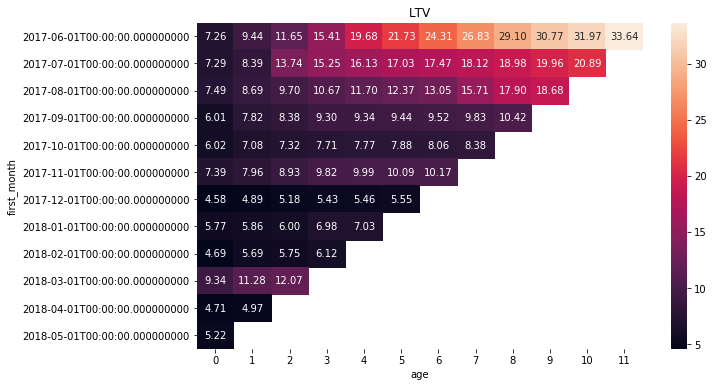

2


3


4


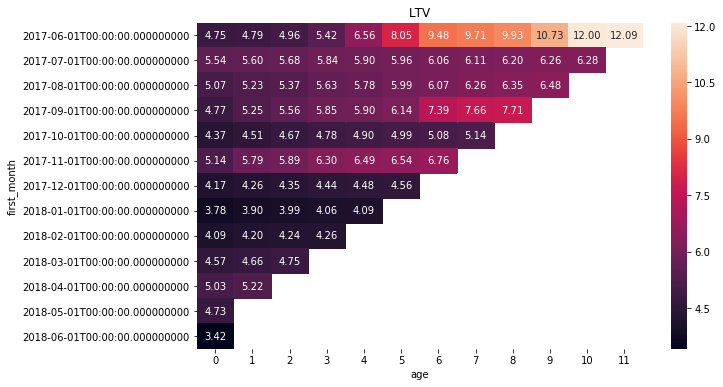

5


7


9


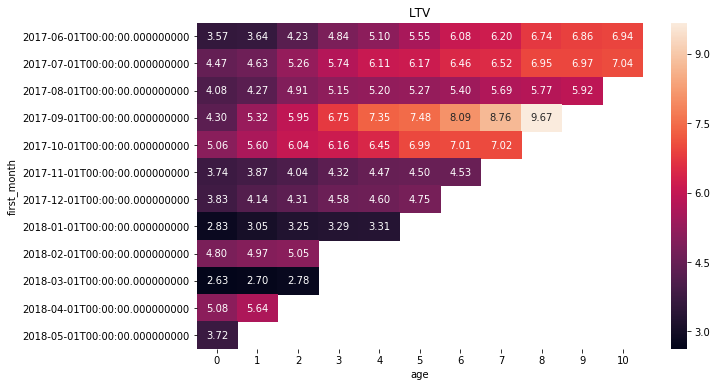

10


In [37]:
for source in sorted(report_source.source_id.unique()):
    
    output_source = report_source.query('source_id == @source').pivot_table(
            index='first_month', 
            columns='age', 
            values='ltv', 
            aggfunc='mean').round(3)

    print(source)
    plt.figure(figsize=(10, 6))
    plt.title('LTV')
    sns.heatmap(output_source.cumsum(axis=1), annot=True, fmt='.2f')
    plt.show()

<font color = olive>
Мне кажется, что столбчатые диаграммы подходят больше, так как позволяют визуально оценить размер LTV для разных групп пользователей в рамках одной когорты (каждый столбец - отдельная когорта, а каждый сектор в столбце соответсвует последнему значению в хитмэп (сумме по строке))
    
Я, к сожалению, не понял для чего мне смотреть на накопление по месяцам. 

<div class="alert alert-danger">
<h2> Комментарий ревьюера (2)</h2>

Я имел ввиду чтобы на столбчатых диаграммах было отражено накопление, т.к. LTV отображается всегда с накопительным итогом. А вместо столбчатой диаграммы линейная будет еще удачнее для чтения.</div>

___
<font color = olive>
UPD 2
    
На графике ниже я отразил средний месячный прирост LTV. Если график нужно строить иначе, напиши, пожалуйста, подробно что должно быть по осям и какие значения использовать. 

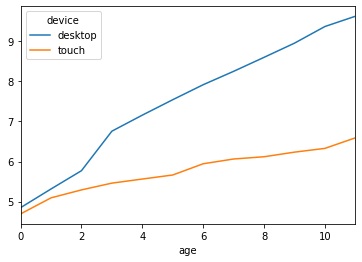

In [38]:
df_source_lines = []

output_device_lines = report_device.pivot_table(
    index='device', 
    columns='age', 
    values='ltv', 
    aggfunc='mean').round(3)

output_device_lines.cumsum(axis=1).T.plot()

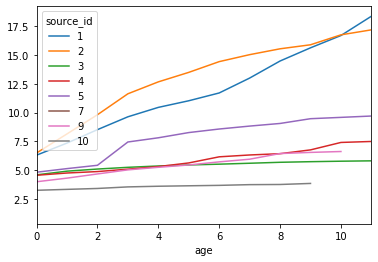

In [39]:
df_source_lines = []

output_source_lines = report_source.pivot_table(
    index='source_id', 
    columns='age', 
    values='ltv', 
    aggfunc='mean').round(3)

output_source_lines.cumsum(axis=1).T.plot()

<div class="alert alert-success">
<h2> Комментарий ревьюера (3)</h2>

Вот отличные и наглядные графики.

___ 

## Маркетинг

Сколько денег потратили? Всего / на каждый источник / по времени


Общие затраты на рекламу: 329131.62


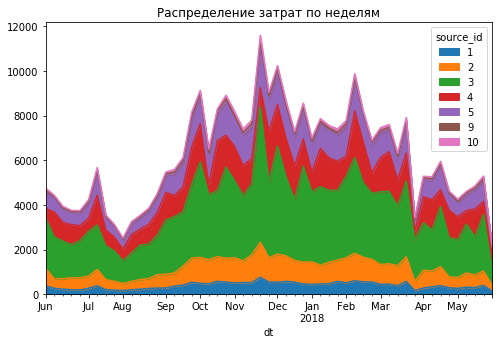

In [40]:
print()
print(f'Общие затраты на рекламу: {costs.costs.sum()}')
costs.groupby('source_id').costs.sum().plot.pie(autopct='%1.1f%%',figsize=(8, 8), startangle=90, labels = None)
plt.legend(costs.source_id.unique())
plt.title('Затраты на разные рекламные источники')
plt.show()

(
    costs
    .pivot_table(columns='source_id', 
                  index = costs.dt.astype('datetime64[W]'), 
                  values = 'costs', 
                  aggfunc = 'sum')
    .plot.area(figsize=(8,5), stacked=True)
)
plt.title('Распределение затрат по неделям')
plt.show()


<div class="alert alert-success">
<h2> Комментарий ревьюера</h2>

Все хорошо. 
</div>

Больше всего денег тратили на "3" рекламный источник, так же в ТОП попали "2", "4" и "5"

___

Сколько стоило привлечение одного покупателя из каждого источника?

In [41]:
users

uid   start_ts  source_id   device  revenue
0           313578113262317 2017-09-18          2  desktop     0.55
1          1575281904278712 2017-06-03         10    touch     3.05
2          2429014661409475 2017-10-11          3  desktop    73.33
3          2464366381792757 2018-01-27          5  desktop     2.44
4          2551852515556206 2017-11-24          5  desktop    10.99
...                     ...        ...        ...      ...      ...
36518  18445147675727495770 2017-08-20          5    touch     3.05
36519  18445407535914413204 2017-09-22          3  desktop     0.88
36520  18445601152732270159 2017-08-07          2  desktop     4.22
36521  18446156210226471712 2017-11-07          3  desktop     9.78
36522  18446167067214817906 2017-10-17          5  desktop     7.94

[36523 rows x 5 columns]

In [42]:
print()
print('Сколько пользователей пришли из разных источников за год:')
users.groupby('source_id').agg({'uid':'nunique'})


Сколько пользователей пришли из разных источников за год:


uid
source_id       
1           2899
2           3506
3          10473
4          10296
5           6931
7              1
9           1088
10          1329

Рассчитаем стоимость привлечения одного пользователя

In [43]:
costs_users = users.groupby(['start_ts', 'source_id']).agg({'uid':'nunique'}).reset_index().merge(costs, 
                                                                                        left_on=['start_ts', 'source_id'],
                                                                                        right_on=['dt', 'source_id']
                                                                                       )
costs_users['cost_per_user'] = costs_users.costs / costs_users.uid
costs_users[:3]

start_ts  source_id  uid         dt   costs  cost_per_user
0 2017-06-01          1   24 2017-06-01   75.20       3.133333
1 2017-06-01          2   28 2017-06-01  132.56       4.734286
2 2017-06-01          3   46 2017-06-01  349.38       7.595217

Отразим полученные данные на графике

In [44]:
costs_users.pivot_table(index=costs_users.start_ts.astype('datetime64[W]'), 
                        columns='source_id', 
                        values='cost_per_user', 
                        aggfunc='mean').plot.area(figsize=(8,5))
plt.title('Средняя стоимость привлечения пользователей из разных рекламных источников')
plt.show()

<div class="alert alert-danger">
<h2> Комментарий ревьюера</h2>

К сожалению САС расчитан не совсем верно, значения получились слишком высокие. Т.к. нам надо считать стоимость привленения покупателя, а не посетителя, дату первого заказа и месяц заказа для подсчета количества покупателей в когортах мы берем из таблицы orders, а из visits берем первый источник с которого пришел клиент.
</div>

---
<font color = olive>
UPD
    
Для расчета затрат я объединил таблицы `users` и `costs`. В таблице `users` содержится информация только о тех пользователях, которые есть в `orders`.Что значит "слишком высокие"?
    
Кста, если бы я смотрел стоимость привлечения посетителя, а не покупателя, САС был бы слишком низким.     
Возможно затраты показались большими из-за использования графика с накоплением
    

Ниже таблица со средним значением привличения покупателя из разных источников

<div class="alert alert-danger">
<h2> Комментарий ревьюера (2)</h2>

Я перпроверил как создавал таблицу users, действительно, там покупатели, а не посетители. Тем не менее, на графике выше значения не соответсвуют средним значениям, которые ты получил ниже, это я имел ввиду под "слишком высокие". А при расчете количества пользователей ты группируешь по времени начала сессии, а не дате первого заказа, из-за чего я подумал, что считаешь пользователей, а не покупателей. Так же САС не нужно отображать с накоплением, это скорее и есть причина высоких значений САС, плюс на графике лучше группировать по месяцу заказа, а не неделям начала сессии. 
</div>

<font color = olive>
UPD 2
    
В таблице `users` дата - начало первой сессии покупателя - дата привлечения покупателя, поэтому я считаю правильным брать расходы именно за этот день.

Если нарисовать график без накопления, многие области сольются и информативность уменьшится.
    
В любом случае, ниже есть две таблицы со средними значениями. Если в одной из них норм значения, убери, пожалуйста, красный комментарий, либо сформулируй замечание четче.


<div class="alert alert-warning">
<h2> Комментарий ревьюера (3)</h2>

Нужно отталкиваться от даты заказа, т.к. не все сессии были с покупками. График рисуется без накопления, т.к. эта метрика показывает конкретно сколько стоило привлечь покупателя, в данном случае за месяц, поэтому и на графике должно быть понятно сколько стоило привлечение в тот или иной месяц из разных источников, а с накоплением мы этого не видим. При правильном построении этого графика можно будет выделить источники с самыми высокими и самыми низкими САС. К средним значеням САС у меня претензий нет, но данный пункт требует правильного отоброжения этой метрики во времени и в разрезе источников для более точного вывода.

In [45]:
costs_users.pivot_table(index=costs_users.start_ts.astype('datetime64[M]'), 
                        columns='source_id', 
                        values='cost_per_user', 
                        aggfunc='mean').plot.area(figsize=(8,5))
plt.title('Средняя стоимость привлечения пользователей из разных рекламных источников')
plt.show()

<font color = olive>
UPD 3
    
У меня получились результаты, которые отличаются от всех предыдущих. Не знаю правильно тут посчитано или нет, но надеюсь ты примешь этот проект.

In [63]:
for_graf = (
    orders
    .merge(users[['uid', 'source_id']], on = 'uid', how = 'left')
    .groupby([orders.buy_ts.astype('datetime64[D]'), 'source_id'])
    .agg({'uid': 'nunique'})
    .reset_index()
)

for_graf = for_graf.merge(costs, left_on = ['buy_ts', 'source_id'], right_on=['dt','source_id'], how='left')

for_graf['cost_per_user'] = for_graf.costs / for_graf.uid

In [64]:
for_graf.pivot_table(index=costs_users.start_ts.astype('datetime64[M]'), 
                        columns='source_id', 
                        values='cost_per_user', 
                        aggfunc='mean').plot.area(figsize=(8,5), stacked=False)
plt.title('Средняя стоимость привлечения пользователей из разных рекламных источников')
plt.show()

In [48]:
for_graf.groupby('source_id').agg({'cost_per_user':'mean'}).sort_values('cost_per_user')

cost_per_user
source_id               
9               4.983649
1               5.631889
10              5.852818
4               6.200855
5               6.609916
2               9.457858
3              12.872329
7                    NaN

<div class="alert alert-warning">
<h2> Комментарий ревьюера (4)</h2>

Да, этот график уже больше похож на тот, что нужен. Единственное, нужно было группировать по дате именно первого заказа, которую нужно было заранее добавить, а не просто по дате заказа.

In [49]:
costs_users.groupby('source_id').agg({'cost_per_user':'mean'}).sort_values('cost_per_user')

cost_per_user
source_id               
10              6.553861
4               6.802483
9               7.152904
5               8.596789
1               9.118983
3              15.118899
2              17.002963

<font color = olive>
Еще ниже - код из слака от сотрудника Практикума. Разность в значениях связана с методом расчета. Я посчитал стоимость привличения по датам, а после консолидировал до источников.
    
А в слаке затраты сразу консолидировали по источникам.

In [50]:
some_shit1 = users.groupby('source_id').agg({'uid':'nunique'})
some_shit1 = some_shit1.merge(costs.groupby('source_id').sum(), on = 'source_id')
some_shit1['mean_cost'] = some_shit1['costs'] / some_shit1['uid']
some_shit1.sort_values('mean_cost')

uid      costs  mean_cost
source_id                             
10          1329    5822.49   4.381106
9           1088    5517.49   5.071222
4          10296   61073.60   5.931779
1           2899   20833.27   7.186364
5           6931   51757.10   7.467479
2           3506   42806.04  12.209367
3          10473  141321.63  13.493901

<font color = olive>

---

Самыми дорогими рекламными источниками оказались "2" и "3".

Наибольшее число пользователей пришло из рекламных источников "3", "4" и "5". По графику выше видно, что у источников "4" и "5" низкая стоимость привлечения клиентов. Возможно стоит уделить больше внимания.

При этом у источника "2" высокая стоимость привлечения клиентов, и оттуда приходит мало людей. Возможно от него стоит отказаться.

___

На сколько окупились расходы? (ROI)

In [51]:
report

first_month   uid curr_month   revenue  age       ltv
0   2017-06-01  2023 2017-06-01   9557.49    0  4.724414
1   2017-06-01  2023 2017-07-01    981.82    1  0.485329
2   2017-06-01  2023 2017-08-01    885.34    2  0.437637
3   2017-06-01  2023 2017-09-01   1931.30    3  0.954671
4   2017-06-01  2023 2017-10-01   2068.58    4  1.022531
..         ...   ...        ...       ...  ...       ...
74  2018-03-01  3533 2018-05-01   1114.87    2  0.315559
75  2018-04-01  2276 2018-04-01  10600.69    0  4.657597
76  2018-04-01  2276 2018-05-01   1209.92    1  0.531599
77  2018-05-01  2988 2018-05-01  13925.76    0  4.660562
78  2018-06-01     1 2018-06-01      3.42    0  3.420000

[79 rows x 6 columns]

In [52]:
report_new = pd.merge(report, costs.groupby(costs.dt.astype('datetime64[M]')).agg({'costs': 'sum'}).reset_index(), left_on='first_month', right_on='dt', how='left')
report_new['cac'] = report_new['costs'] / report_new['uid']
report_new['roi'] = report_new['ltv'] / report_new['cac']

output_roi = report_new.pivot_table(
        index='first_month', 
        columns='age', 
        values='roi', 
        aggfunc='mean')

In [53]:
report_new

first_month   uid curr_month   revenue  age       ltv         dt     costs  \
0   2017-06-01  2023 2017-06-01   9557.49    0  4.724414 2017-06-01  18015.00   
1   2017-06-01  2023 2017-07-01    981.82    1  0.485329 2017-06-01  18015.00   
2   2017-06-01  2023 2017-08-01    885.34    2  0.437637 2017-06-01  18015.00   
3   2017-06-01  2023 2017-09-01   1931.30    3  0.954671 2017-06-01  18015.00   
4   2017-06-01  2023 2017-10-01   2068.58    4  1.022531 2017-06-01  18015.00   
..         ...   ...        ...       ...  ...       ...        ...       ...   
74  2018-03-01  3533 2018-05-01   1114.87    2  0.315559 2018-03-01  30415.27   
75  2018-04-01  2276 2018-04-01  10600.69    0  4.657597 2018-04-01  22289.38   
76  2018-04-01  2276 2018-05-01   1209.92    1  0.531599 2018-04-01  22289.38   
77  2018-05-01  2988 2018-05-01  13925.76    0  4.660562 2018-05-01  22224.27   
78  2018-06-01     1 2018-06-01      3.42    0  3.420000        NaT       NaN   

         cac       roi  
0   8.905091  0.530530  
1   8.905091  0.054500  
2   8.905091  0.049145  
3   8.905091  0.107205  
4   8.905091  0.114825  
..       ...       ...  
74  8.608907  0.036655  
75  9.793225  0.475594  
76  9.793225  0.054282  
77  7.437841  0.626601  
78       NaN       NaN  

[79 rows x 10 columns]

In [54]:
plt.figure(figsize=(10, 6))
plt.title('ROI')
sns.heatmap(output_roi.cumsum(axis=1), annot=True, fmt='.2f')
plt.show()

<div class="alert alert-warning">
<h2> Комментарий ревьюера</h2>

А здесь правильные данные использованы и romi вышел правильный. Надо к этой таблице применить метод mean() и мы узнаем через сколько месяцев окупаются в среднем наступает окупаемость.
</div>

Видно, что окупились только две когорты (06-2017 и 09-2017). Наверное, это плохо. Стоит либо меньше тратить на рекламу, либо постараться вернуть клиентов с помощью email рассылок или вроде того

In [55]:
report_source_new = pd.merge(report_source, costs, left_on=['first_month','source_id'], right_on=['dt','source_id'], how='left')
report_source_new['cac'] = report_source_new['costs'] / report_source_new['uid']
report_source_new['roi'] = report_source_new['ltv'] / report_source_new['cac']

output_roi_source = report_source_new.pivot_table(
        index='first_month', 
        columns='age', 
        values='roi', 
        aggfunc='mean')

display(report_source_new)
output_roi_source

first_month  source_id  uid curr_month  revenue_users  age       ltv  \
0    2017-06-01          1  190 2017-06-01        1378.70    0  7.256316   
1    2017-06-01          1  190 2017-07-01         414.98    1  2.184105   
2    2017-06-01          1  190 2017-08-01         419.43    2  2.207526   
3    2017-06-01          1  190 2017-09-01         714.24    3  3.759158   
4    2017-06-01          1  190 2017-10-01         811.20    4  4.269474   
..          ...        ...  ...        ...            ...  ...       ...   
511  2018-05-01          4  804 2018-05-01        3802.91    0  4.729988   
512  2018-05-01          5  497 2018-05-01        2094.04    0  4.213360   
513  2018-05-01          9   60 2018-05-01         223.05    0  3.717500   
514  2018-05-01         10  130 2018-05-01         470.89    0  3.622231   
515  2018-06-01          4    1 2018-06-01           3.42    0  3.420000   

            dt   costs       cac        roi  
0   2017-06-01   75.20  0.395789  18.333777  
1   2017-06-01   75.20  0.395789   5.518351  
2   2017-06-01   75.20  0.395789   5.577527  
3   2017-06-01   75.20  0.395789   9.497872  
4   2017-06-01   75.20  0.395789  10.787234  
..         ...     ...       ...        ...  
511 2018-05-01  130.82  0.162711  29.069791  
512 2018-05-01   79.99  0.160946  26.178772  
513 2018-05-01    8.28  0.138000  26.938406  
514 2018-05-01   10.02  0.077077  46.995010  
515        NaT     NaN       NaN        NaN  

[516 rows x 11 columns]

age                 0         1          2          3         4         5   \
first_month                                                                  
2017-06-01   17.070128  1.807756   2.122752   3.948071  4.188732  3.173013   
2017-07-01   56.046102  5.350392  26.101795   7.270278  4.968364  4.582381   
2017-08-01   23.500586  1.879348   2.280692   1.987414  2.115965  1.387847   
2017-09-01   30.913042  7.337385   3.137885  14.068881  1.985657  2.913488   
2017-10-01   33.303295  3.741937   1.358995   1.056080  1.048560  1.033040   
2017-11-01   27.769510  2.130837   1.178425   2.056086  0.868536  0.297571   
2017-12-01   24.479885  1.319647   3.807253   4.373082  1.191650  1.322627   
2018-01-01   16.851245  1.115294   1.233605   0.784650  0.275780       NaN   
2018-02-01   70.193256  2.383919   0.678886   0.666834       NaN       NaN   
2018-03-01   26.634443  1.920790   1.443116        NaN       NaN       NaN   
2018-05-01   36.265967       NaN        NaN        NaN       NaN       NaN   

age                6         7         8         9         10        11  
first_month                                                              
2017-06-01   4.134148  2.338729  2.164883  2.586853  2.262106  1.223259  
2017-07-01   2.828636  3.382831  4.159755  4.884959  4.706634       NaN  
2017-08-01   1.058643  1.918497  1.460258  0.908061       NaN       NaN  
2017-09-01   5.112299  1.767401  1.692285       NaN       NaN       NaN  
2017-10-01   0.508190  0.815555       NaN       NaN       NaN       NaN  
2017-11-01   0.640888       NaN       NaN       NaN       NaN       NaN  
2017-12-01        NaN       NaN       NaN       NaN       NaN       NaN  
2018-01-01        NaN       NaN       NaN       NaN       NaN       NaN  
2018-02-01        NaN       NaN       NaN       NaN       NaN       NaN  
2018-03-01        NaN       NaN       NaN       NaN       NaN       NaN  
2018-05-01        NaN       NaN       NaN       NaN       NaN       NaN

In [56]:
df_source = pd.DataFrame()
for source in sorted(report_source_new.source_id.unique()):
    output_source_roi = report_source_new.query('source_id == @source').pivot_table(
        index='first_month', 
        columns='age', 
        values='roi', 
        aggfunc='mean').round(3)
    df_source[source] = output_source_roi.sum(axis=1)
    
    
df_source.plot.bar(stacked=True, figsize=(12,8))
plt.title("Сравнение ROI разных когорт")
plt.xlabel("Когорта")
plt.show()


<div class="alert alert-danger">
<h2> Комментарий ревьюера</h2>
А вот romi в разрезе источников нужно поправить, обрати внимания на значения, они получились нереально большими. Судя по ним все окупилось в первый же месяц. Плюс на этом графике не отражен накопительный итог. И вместо такого типа диаграм рекомендую попробовать линейную диаграмму, она существенно упростит и сделает его читабельней, такой график выше тоже рекомендую заменить на линейную.
</div>

---
<font color = olive>
UPD
    
Действительно, для расчета САС я брал затраты только за первый день месяца, поэтому ROI получился слишком большим

In [57]:
report_source_new = pd.merge(report_source, costs.groupby([costs.dt.astype('datetime64[M]'), 'source_id']).agg({'costs': 'sum'}).reset_index(), left_on=['first_month','source_id'], right_on=['dt','source_id'], how='left')
report_source_new['cac'] = report_source_new['costs'] / report_source_new['uid']
report_source_new['roi'] = report_source_new['ltv'] / report_source_new['cac']


Source_id = 1


Source_id = 2


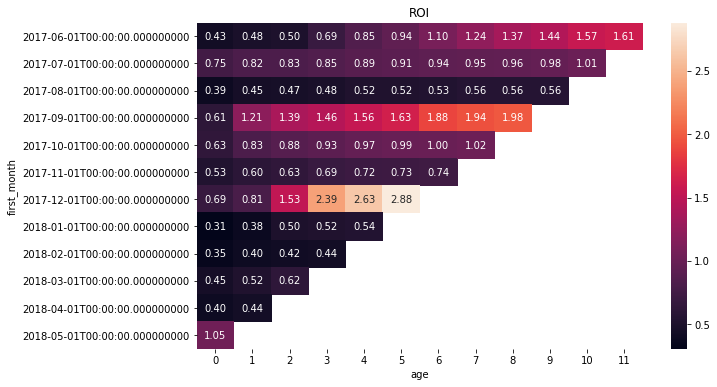

Source_id = 3


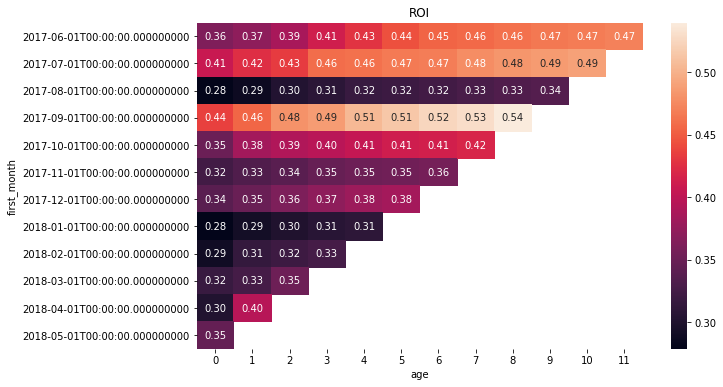

Source_id = 4


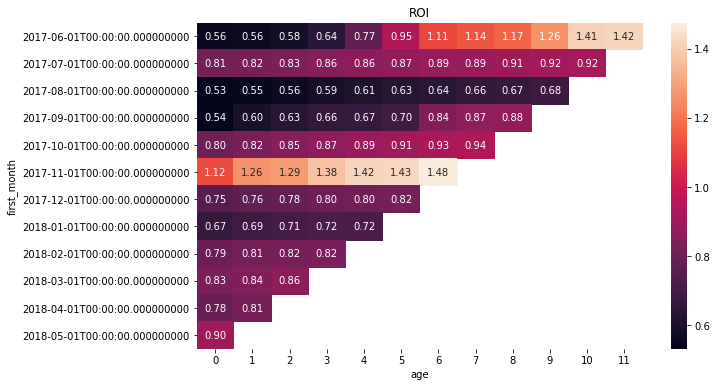

Source_id = 5


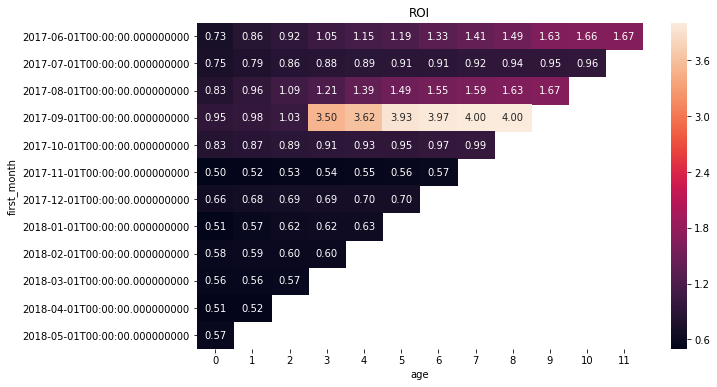

Source_id = 9


Source_id = 10


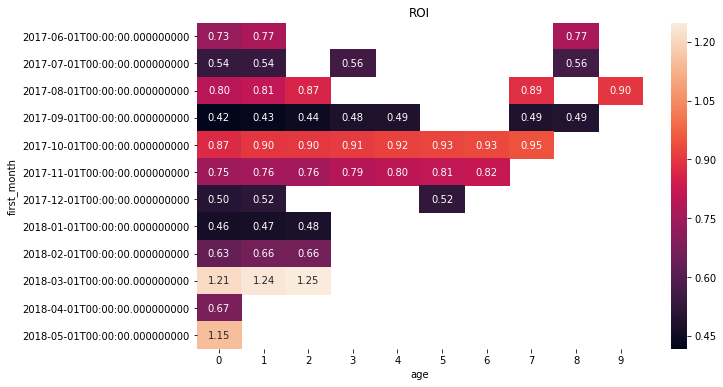

In [58]:
source_mean = {}
for source in report_source_new.source_id.unique():
    if source == 7:
        continue
        
    output_source_roi = report_source_new.query('source_id == @source').pivot_table(
            index='first_month', 
            columns='age', 
            values='roi', 
            aggfunc='mean')
    
    source_mean[source] = output_source_roi.cumsum(axis=1)[5].mean()
    
    print(f'Source_id = {source}')

    plt.figure(figsize=(10, 6))
    plt.title('ROI')
    sns.heatmap(output_source_roi.cumsum(axis=1), annot=True, fmt='.2f')
    plt.show()

<font color = olive>
Для определения наиболее выгодного источника, определим средний ROI на шестой месяц (таким образом мы используем в расчетах половину имеющихся когорт)

In [59]:
sorted(source_mean.items(), key=lambda x: x[1], reverse=True)

[(1, 1.7685762519562236),
 (5, 1.3877311463832827),
 (2, 1.2294956569473143),
 (9, 1.2162181621522414),
 (4, 0.9002968563933978),
 (10, 0.7540707529856999),
 (3, 0.413851219275537)]

<font color = olive>
Видно, что лучшие результаты у источников 1, 5, 2
    

<div class="alert alert-danger">
<h2> Комментарий ревьюера (2) </h2>

По такому каскаду тепловых карт сложно делать сравнение, поэтому в них нет особого смысла. Вместо них нужно на одном графике показать окупаемость всех источников без разбиения на месячные когорты. Линейная диаграмма будет самым удачным вариантом для этого. А средние для истончиков посчитаны правильно. Для информации, все же тут мы считаем romi, а не roi.
</div>

___
<font color = olive>
UPD 2
    
Я попробовал нарисовать график, надеюсь в этот раз норм

In [60]:
output_source_roi_lines = report_source_new.pivot_table(
            index='source_id', 
            columns='age', 
            values='roi', 
            aggfunc='mean')

output_source_roi_lines.cumsum(axis=1).T.plot(grid=True)

<div class="alert alert-success">
<h2> Комментарий ревьюера (3)</h2>

Да, это именно то, что нужно. 
</div>

# Вывод

Судя по LTV, я бы порекомендовал сосредоточиться на desktop и `source_id =` "1", "2", так как они приносят больше денег.


<div class="alert alert-danger">
<h2> Комментарий ревьюера</h2>

В конце работы нужно написать выводы по каждому сделанному пункту в работе,поэтому попрошу тебя их здесь написать и пересмотреть рекомендации после исправлений выше. 
</div>

___

<font color = olive>
UPD
    
* Среднее количество пользователей в день - 907, в неделю - 5724, в месяц - 23228
* Среднее количество сессий в день - 987
* Половина всех сессий длится менее 5 минут

    
* Для того, чтобы совершить покупку, половине пользователей хватает 16 минут
* В среднем, за месяц совершается одна покупка
* Средний чек за месяц составляет 5,87
* В плане LTV, десктоп лучше мобильных устройств, а среди рекламных источников лидируют "1" и "2"

    
* Всего за год на рекламу потратили 330 000, больше всего на источники "3" и "4", наибольшие траты на рекламу были с ноября по март
* Наиболее дорогими источниками привлечения были "2" и "3", самыми дешевыми - "10" и "4"
* ROI больше единицы только у двух когорт
* В разрезе рекламных источников лучшие результаты у "1", "5", "2", "9". Худшие - "3" и "10".
    
Рекомендации:
Я бы порекомендовал сосредоточиться на desktop и source_id = "1", "5", "9", так как они приносят больше денег.


<font color='blue'> 
## Комментарий от ревьюера
<t>    
Поздравляю, ты провел отличную работу. Было действительно интересно проверять твой проект и следить за ходом твоих мыслей. В нем много удачных решений, ты хорошо владеешь pandas и строишь хорошие графики. В работе еще осталось уточнить несколько моментов из задания и построить несколько графиков, без которых сложно правильно ответить на финальный вопрос о выгодности источников. Ниже я продублирую список корректировок и графиков нужных для принятия проекта:

1— Уточнить ответ про то сколько раз покупает за период покупатель и средний чек
    
2— Поправить графики LTV в разрезах, чтобы были с накоплением

3— Поправить расчеты САС и график изменения САС по месяцам в разрезе источников

4— Дополнить ответ про romi значением среднего количества месяцев до окупаемости и пооправить расчеты и график romi в разрезе источников
    
5— После построения этих графиков могут появиться новые выводы и рекомендации, поэтому их стоит пересмотреть. И допиши, пожалуйста, выводы в конце работы.

6— Ну и по желанию поправить по желтым комментариям

Т.к. в этой работе и в следующих проектах придется строить графики со своей стороны рекомендую поглубже изучить библиотеку seaborn и посмотреть ресурс https://python-graph-gallery.com с множеством готовых решений, которые можешь просто забирать себе.

Жду твоих исправлений:)

<font color='blue'> 
## Комментарий от ревьюера (2)
<t>  
Ты отлично постарался и исправил практически все пункты с прошлого ревью, это отличный результат. Я уже начал переживать, что ты долго не присылаешь свою работу, надеюсь у тебя все хорошо. Осталось несколько пунктов, которые все еще нужно подправить и проект будет завершен:
- Поправить графики LTV в разрезах, чтобы были с накоплением
- Поправить расчеты САС и график изменения САС по месяцам в разрезе источников
- Построить 1 график ROMI в разрезе источников

Поправляй скорее эти пункты и присылай обратно.    
    

<font color='blue'> 
## Комментарий от ревьюера (3)
<t>  
Ты молодец, оперативно сделал исправления. В этот раз я не оставил красных комментариев, т.к. считаю что основная задача теперь выполнена и получены верные выводы. Но я все же хотел бы, чтобы ты поправил пункт с расчетом и графиком САС и оставил их в итоге корректными. Если посчитаешь это ненужным, присылай обратно, я приму проект.

<font color='blue'> 
## Комментарий от ревьюера (4)
<t>
Спасибо, что решил поправить последний пункт. Теперь тебя можно окончательно поздравить с завершением проекта, он принят. По итогу у тебя получилась очень достойная работа. Да, кое-где еще остались шероховатости и моменты для улучшения, но это нормально на данном этапе. Мне остается только пожелать тебе успехов в дальнейшем обучении. Буду рад если смог помочь узнать что-то новое для себя. Продолжай так же стараться и все у тебя получится)